In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from generate_embeddings import get_wine_dataframe
from notebooks.helpers.prep.view_embeddings import view_embeddings_of_ingredient
from generate_pairings import compute_embedding_food_ingredients, get_the_closest_embedding, get_food_embedding_dict, get_descriptor_frequencies, get_production_wines
import networkx as nx
from pyvis.network import Network as net


In [3]:
wine_dataframe = get_wine_dataframe()

In [4]:
wine_dataframe = wine_dataframe.head(20)
wine_dataframe.columns = map(str.lower, wine_dataframe.columns)
wine_dataframe.rename(inplace=True, columns = {'name':'wine'})

wine_dataframe['vintage'] = wine_dataframe['vintage'].apply(lambda x: int(x))

In [5]:
wine_dataframe.columns


Index(['alcohol', 'category', 'country', 'wine', 'price', 'province', 'region',
       'variety', 'vintage', 'winery', 'geo_normalized', '0',
       'clean_descriptions', 'descriptors_in_reviews'],
      dtype='object')

In [6]:
map_columns_to_relationship = {
    'variety': {'category': 'from_category'},
    'wine': {
        'alcohol': 'has_alcohol',
        'category': 'has_category',
        'price':'has_price',
        'region': "from_region",
        'variety': "has_variety",
        'vintage': "vintage_year",
        'winery': "from_winery",
    },
    'province': {
        'country': 'from_country',
    },
    'region':{
        'country': 'from_country'
    },
    'winery':{
        'province': 'from_province',
        'geo_normalized': 'from_location'
    }
}

skip_columns = ['0']

In [7]:
def create_nodes_from_instance( instance, mapper):
    instance_sources = []
    instance_targets = []
    instance_source_labels = []
    instance_target_labels = []
    relations = []
    for source, targets in mapper.items():    
        source_value = instance[source]
        source_label = source

        if source_value is np.nan or source_value == 'none':
            continue
        
        for target, relation in targets.items():
            target_value = instance[target]
            target_label = target

            if target_value is np.nan or target_value == 'none':
                continue
            
            relations.append(relation)
            instance_sources.append(str(source_value))
            instance_targets.append(target_value)
            instance_source_labels.append(source_label)
            instance_target_labels.append(target_label)


    return instance_sources, instance_targets, relations, instance_source_labels,instance_target_labels


In [8]:
heads, tails, edges, head_labels, target_labels = [], [], [], [], []
for _, instance in wine_dataframe.iterrows():
    instance_sources, instance_targets, relations, instance_source_labels, instance_target_labels = create_nodes_from_instance(instance, map_columns_to_relationship)
    heads.extend(instance_sources)
    edges.extend(relations)
    tails.extend(instance_targets)
    head_labels.extend(instance_source_labels)
    head_labels.extend(instance_target_labels)

In [12]:
KG = pd.DataFrame({'head': heads, "tail": tails, 'edges': edges
})
# G=nx.from_pandas_edgelist(KG, "head", "tail", edge_key = 'labels', create_using=nx.MultiDiGraph())

G = nx.DiGraph()
for _, row in KG.iterrows():
    G.add_edge(row['head'], row['tail'], label=row['edges'])
    # G.nodes[row['tail']]['label'] = row['node_label']

In [14]:
# for edge in G.edges(data=True):
#     print(edge)

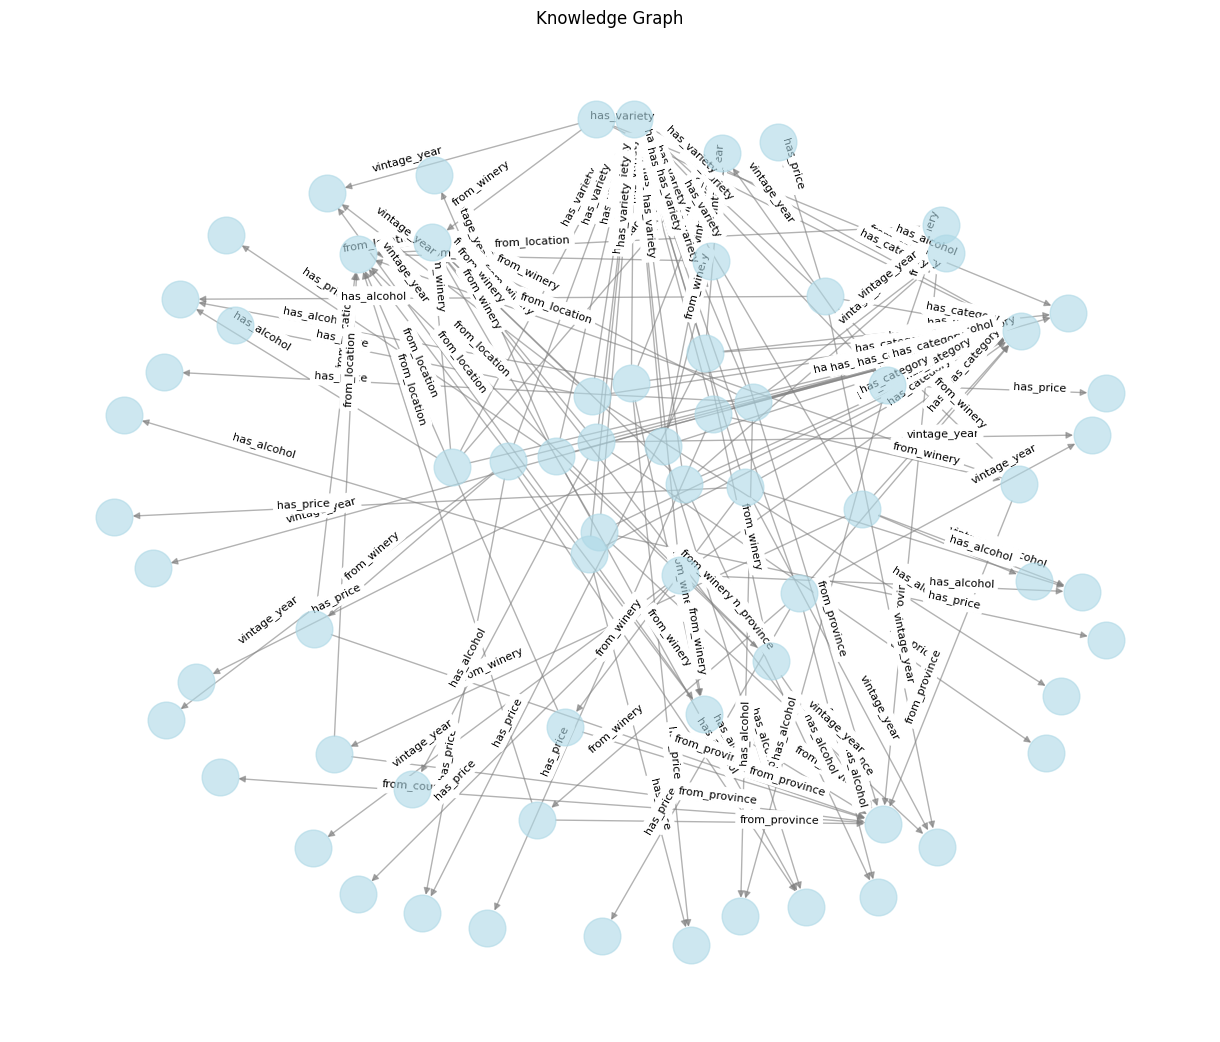

In [20]:
pos = nx.spring_layout(G, seed=42, k=1)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

In [ ]:
nt = net(cdn_resources='in_line')
nt.from_nx(G)
nt.prep_notebook()
nt.show("nx.html")

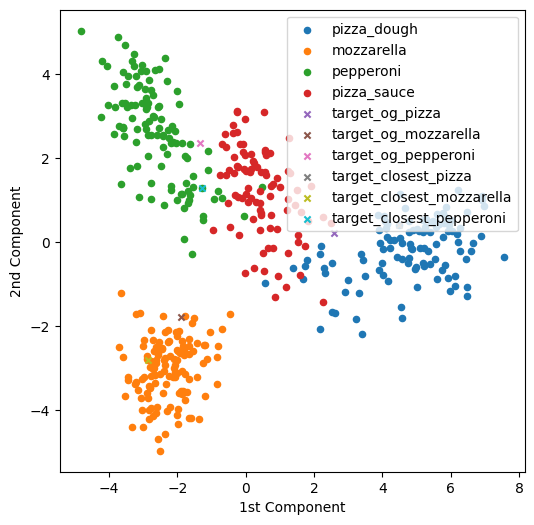

In [3]:
ingredients = [
        "pizza_dough",
        "mozzarella",
        "pepperoni",
        "pizza_sauce",
    ]
food_to_embeddings_dict = get_food_embedding_dict()


dish_embeddings = compute_embedding_food_ingredients(ingredients)

closest_embeddings, simi = get_the_closest_embedding( food_to_embeddings_dict, dish_embeddings)

targets = {
    'og_pizza' : dish_embeddings['pizza_dough'],
    'og_mozzarella' : dish_embeddings['mozzarella'],
    'og_pepperoni' : dish_embeddings['pepperoni'],
    'closest_pizza': closest_embeddings['pizza_dough'],
    'closest_mozzarella': closest_embeddings['mozzarella'],
    'closest_pepperoni': closest_embeddings['pepperoni'],
    
}
view_embeddings_of_ingredient(ingredients=ingredients, targets=targets, N=2)

In [190]:
descriptor_frequencies = get_descriptor_frequencies()
wines = get_production_wines()

In [191]:
descriptor_frequencies.index

Index(['Red Blends, Red Blends San Francisco Bay, Central Coast, California, USA',
       'Ribolla Gialla, Italian White Friuli-Venezia Giulia, Northeast Italy, Italy',
       'Viognier Southern Oregon, Oregon, USA',
       'Cabernet Franc Sierra Foothills, California, USA',
       'Cabernet Franc Sonoma Valley, North Coast, California, USA',
       'Red Blends, Red Blends Le Marche, Central Italy, Italy',
       'Pinot Noir Cote de Beaune, Burgundy, France',
       'Chardonnay Maule Valley, Central Valley, Chile',
       'Merlot Finger Lakes, New York, USA',
       'Zinfandel San Francisco Bay, Central Coast, California, USA',
       ...
       'Red Blends, Red Blends Mendoza, Argentina',
       'Red Blends, Red Blends Mendocino, North Coast, California, USA',
       'Red Blends, Red Blends Sardinia, Southern Italy, Italy',
       'White Blend Friuli-Venezia Giulia, Northeast Italy, Italy',
       'Dolcetto, Italian Red Piedmont, Northwest Italy, Italy',
       'Malbec Southwest Franc

In [192]:
wines.index

Index(['Aglianico, Italian Red Basilicata, Southern Italy, Italy',
       'Aglianico, Italian Red Campania, Southern Italy, Italy',
       'Alsace white blend, White Blend Alsace, France',
       'Arneis, Italian White Piedmont, Northwest Italy, Italy',
       'Austrian Red Blend, Red Blends Burgenland, Austria',
       'Austrian white blend, White Blend Burgenland, Austria',
       'Austrian white blend, White Blend Niederosterreich, Austria',
       'Bordeaux-style Red Blend Bourg & Blaye, Bordeaux, France',
       'Bordeaux-style Red Blend Coastal Region, South Africa',
       'Bordeaux-style Red Blend Colchagua Valley, Central Valley, Chile',
       ...
       'White Blend Veneto, Northeast Italy, Italy',
       'Zinfandel Clear Lake, North Coast, California',
       'Zinfandel Columbia Valley, Washington, USA',
       'Zinfandel Inland Valleys, California, USA',
       'Zinfandel Mendocino, North Coast, California, USA',
       'Zinfandel Napa Valley, North Coast, California, USA'

In [10]:
descriptor_frequencies

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
"Red Blends, Red Blends San Francisco Bay, Central Coast, California, USA","('cherry', '26.0')","('blackberry', '21.0')","('fruit', '21.0')","('ripe', '16.0')","('berry', '12.0')","('plum', '12.0')","('concentrated', '11.0')","('dark', '11.0')","('spice', '10.0')","('black_cherry', '8.0')","('cedar', '8.0')","('blueberry', '7.0')","('easy', '7.0')","('leather', '6.0')","('tobacco', '6.0')"
"Ribolla Gialla, Italian White Friuli-Venezia Giulia, Northeast Italy, Italy","('apple', '20.0')","('citrus', '19.0')","('white', '18.0')","('peach', '18.0')","('yellow', '15.0')","('mineral', '15.0')","('stone_fruit', '13.0')","('linear', '11.0')","('zest', '9.0')","('spring_flower', '8.0')","('fruit', '8.0')","('pear', '7.0')","('tangerine', '7.0')","('apricot', '7.0')","('savory', '5.0')"
"Viognier Southern Oregon, Oregon, USA","('fruit', '44.0')","('citrus', '39.0')","('peach', '33.0')","('lemon', '22.0')","('ripe', '20.0')","('grapefruit', '18.0')","('lime', '18.0')","('pineapple', '16.0')","('melon', '14.0')","('rind', '14.0')","('orange', '12.0')","('apricot', '12.0')","('pear', '11.0')","('apple', '10.0')","('fruity', '9.0')"
"Cabernet Franc Sierra Foothills, California, USA","('fruit', '19.0')","('black_cherry', '14.0')","('ripe', '13.0')","('oak', '9.0')","('cherry', '8.0')","('blackberry', '7.0')","('spice', '6.0')","('cinnamon', '6.0')","('chocolate', '5.0')","('savory', '5.0')","('plum', '5.0')","('concentrated', '5.0')","('vanilla', '4.0')","('smoky', '4.0')","('raspberry', '4.0')"
"Cabernet Franc Sonoma Valley, North Coast, California, USA","('oak', '10.0')","('cherry', '9.0')","('fruit', '8.0')","('juicy', '7.0')","('raspberry', '7.0')","('dried_herb', '7.0')","('violet', '7.0')","('leather', '7.0')","('tobacco', '6.0')","('cedar', '6.0')","('blackberry', '5.0')","('plum', '5.0')","('clove', '5.0')","('complex', '4.0')","('concentrated', '4.0')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Malbec Southwest France, France","('fruit', '332.0')","('ripe', '192.0')","('wood', '187.0')","('black_fruit', '186.0')","('dense', '157.0')","('juicy', '132.0')","('dark', '126.0')","('powerful', '126.0')","('plum', '108.0')","('concentrated', '103.0')","('berry', '97.0')","('fruity', '88.0')","('blackberry', '68.0')","('spice', '66.0')","('black_currant', '56.0')"
"Zinfandel Mendocino, North Coast, California, USA","('fruit', '50.0')","('blackberry', '39.0')","('ripe', '36.0')","('raspberry', '29.0')","('cherry', '24.0')","('spice', '22.0')","('fruity', '19.0')","('strawberry', '18.0')","('berry', '17.0')","('concentrated', '16.0')","('oak', '15.0')","('boysenberry', '10.0')","('plum', '10.0')","('juicy', '10.0')","('easy', '9.0')"
"White Blend Southern Greece, Greece","('white', '24.0')","('citrus', '20.0')","('spice', '16.0')","('fruit', '13.0')","('peach', '13.0')","('lemon', '12.0')","('flower', '10.0')","('tropical_fruit', '7.0')","('melon', '7.0')","('cheese', '6.0')","('orange', '6.0')","('pear', '5.0')","('minerality', '5.0')","('easy', '3.0')","('round', '3.0')"
"Cannonau, Grenache Sardinia, Southern Italy, Italy","('raspberry', '16.0')","('black_cherry', '16.0')","('cherry', '14.0')","('ripe', '13.0')","('juicy', '12.0')","('clove', '12.0')","('spice', '10.0')","('leather', '10.0')","('red_berry', '9.0')","('licorice', '9.0')","('fruit', '9.0')","('blackberry', '8.0')","('game', '8.0')","('wild_berry', '7.0')","('herb', '7.0')"


In [28]:
index = descriptor_frequencies.index
columns = descriptor_frequencies.columns
descriptors = []

for _, variety in descriptor_frequencies.iterrows():
    desc = []
    for column in columns[:5]:
        descriptor = variety[column]
        descriptor = eval(descriptor)
        desc.append(descriptor[0])
    descriptors.append(desc)


In [194]:
desc_df = pd.DataFrame({'descriptors': descriptors}, index=index )

In [195]:
desc_df

,descriptors
"Red Blends, Red Blends San Francisco Bay, Central Coast, California, USA","[cherry, blackberry, fruit, ripe, berry]"
"Ribolla Gialla, Italian White Friuli-Venezia Giulia, Northeast Italy, Italy","[apple, citrus, white, peach, yellow]"
"Viognier Southern Oregon, Oregon, USA","[fruit, citrus, peach, lemon, ripe]"
"Cabernet Franc Sierra Foothills, California, USA","[fruit, black_cherry, ripe, oak, cherry]"
"Cabernet Franc Sonoma Valley, North Coast, California, USA","[oak, cherry, fruit, juicy, raspberry]"
...,...
"Malbec Southwest France, France","[fruit, ripe, wood, black_fruit, dense]"
"Zinfandel Mendocino, North Coast, California, USA","[fruit, blackberry, ripe, raspberry, cherry]"
"White Blend Southern Greece, Greece","[white, citrus, spice, fruit, peach]"
"Cannonau, Grenache Sardinia, Southern Italy, Italy","[raspberry, black_cherry, cherry, ripe, juicy]"


In [199]:
wines_df = pd.merge(desc_df, wines, right_index=True, left_index=True)

In [201]:
wines_df[wines_df.index == 'Pinot Grigio Alsace, France']

,descriptors,aroma,weight,sweet,acid,salt,piquant,fat,bitter,flavor
"Pinot Grigio Alsace, France","[pear, ripe, fruit, spice, concentrated]",[ 7.29411989e-02 -1.69070393e-01 1.20017886e-...,0.627409,0.754484,0.45204,0.613289,0.324822,0.294084,0.096218,0.346571


In [165]:
taste = 'bitter'
wines_df[taste].mean()


0.2998224656277792

In [176]:

print(wines_df.value_counts(wines_df[taste].apply(lambda x: x > 0 and x <= 0.12)))
print(wines_df.value_counts(wines_df[taste].apply(lambda x: x > 0.12 and x <= 0.3 )))
print(wines_df.value_counts(wines_df[taste].apply(lambda x: x > 0.3 and x <= 0.5 )))
print(wines_df.value_counts(wines_df[taste].apply(lambda x: x > 0.5 and x <= 1 )))
# print(wines_df.value_counts(wines_df['salt'].apply(lambda x: x > 0.8 and x <= 1 )))


bitter
False    333
True     144
Name: count, dtype: int64
bitter
False    344
True     133
Name: count, dtype: int64
bitter
False    378
True      99
Name: count, dtype: int64
bitter
False    377
True     100
Name: count, dtype: int64
